# String Method for Free Energy Pathway Sampling
<div class="alert alert-block alert-info">
    <b>Note:</b> This notebook uses ipyparallel and mpi4py for parallel distribution of string beads. It takes about 20 minutes to complete running interactively on an 8-core Intel 2.3 GHz processor MacBookPro using 8 parallel tasks and the parameters specified below.</div>

## <u>Objective</u>
> ## Construct the minimum (free) energy path for transitions between two distinct states of a biopolymer using the Harmonic Fourier Bead String method.
## <u>Citation</u> 
> ### IV Khavrutskii, K Arora and CL Brooks III. Harmonic Fourier beads method for studying rare events on rugged energy surfaces. *J Chem Phys*, **2006**, 125:174108.

## This example uses the the simple blocked alaninie dipeptide and searches the (free) energy landscape to find the minimum (free) energy pathway between the two endpoint conformations.
## We carry-out the search in this example using the simple vacuum surface and energy minimization. Therefore, we are finding the minimum energy pathway. However, the minimum free energy pathway can also be found if we use molecular dynamics at a given temperature to sample the free energy path.
## <u>Options in this notebook cover:</u>
> ##  - String with vacuum surface using minimization or MD
> ##  - String with GBMV implicit solvent surface using minimization or MD
> ##  - String with explicit solvent using MD
## Set-up parallel stuff specifying 8 processes to manage our 32 beads in the string calculation.

In [1]:
import ipyparallel as ipp
cluster = ipp.Cluster(engines="MPI",n=8)
cluster.start_and_connect_sync()

Starting 8 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/8 [00:00<?, ?engine/s]

## 1. Set-up needed python libraries and MPI
## 2. Fix parameters for this specific calculation
<div class="alert alert-block alert-info">
    <b>Note:</b> We use ipyparallel "magics" (<i>%%px</i>) to enable parallel execution of the cell blocks</div>

In [2]:
%%px
# This script implements a sting path optimization using HFB and
# plots the progress on the alanine dipeptide phi/psi (f/y) map using pyCHARMM
# Written by C.L. Brooks III, November 10, 2020

import os
import sys
import subprocess
import numpy as np
import pandas as pd
import shlex

import pycharmm
import pycharmm.generate as gen
import pycharmm.ic as ic
import pycharmm.coor as coor
import pycharmm.energy as energy
import pycharmm.dynamics as dyn
import pycharmm.nbonds as nbonds
import pycharmm.minimize as minimize
import pycharmm.crystal as crystal
import pycharmm.select as select
import pycharmm.image as image
import pycharmm.psf as psf
import pycharmm.param as param
import pycharmm.read as read
import pycharmm.write as write
import pycharmm.settings as settings
import pycharmm.cons_harm as cons_harm
import pycharmm.cons_fix as cons_fix
import pycharmm.cons_methods as cons_methods
import pycharmm.shake as shake
import pycharmm.scalar as scalar
import pycharmm.charmm_file as charmm_file

# Now we will loop over beads, w/ each bead assigned to
# a a computational node, where node = rank in python mpi
# set up a communicator and get the rank of this process
# Global variables
# Add in mpi support
from mpi4py import MPI
comm = MPI.COMM_WORLD
nproc = comm.Get_size()
rank = comm.Get_rank()

gpusperproc = 1  # number of gpus available on each node, should match nproc
nbeads = 32  # We'll do a path with 32 beads
firststep = 0
nsteps = 2001 #2001
update = 250  #500
# This parameter should be 1 when one is generating the first pass of the string path
# values greater than 1 jump along an existing path and display the evolution every skip
# steps.
skip = 1    #500
inter = True # make interactive plots of progress
gbmv = False  #False
usemd = False
useomm = False
nstep = 1000
nsavc = 100
if gbmv:   # For use with implicit solvent
    path = 'gbmv'
    apnd = '_gbmv'
else:      # For vacuum runs
    path = 'vacuum'
    apnd = ''
# template for f/y restraints
Fcons = '1 cy 1 n 1 ca 1 c'
Ycons = '1 n 1 ca 1 c 1 nt'

%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

## The subsequent cell contains a number of working functions defined to enable the scripting of the HFB string calculation.
<div class="alert alert-block alert-info">
    <b>Note:</b> We use ipyparallel "magics" (<i>%%px</i>) to enable parallel execution of the cell blocks</div>

In [3]:
%%px
def set_beta(beta):
    n = psf.get_natom()
    fbetas = [0.0] * n
    for i, v in enumerate(pycharmm.SelectAtoms(hydrogens=True)):
        if not v:
            fbetas[i] = beta

    dyn.set_fbetas(fbetas)

def evolve_String(ibead,istep):
    # turn off the noise
    # Evolve each bead by minimization
    trj = charmm_file.CharmmFile('{}/dcd_evolve/refine_{}.dcd'.format(path,istep),
                           file_unit=1,
                           formatted=False,
                           read_only=True)
    traj_read = '''
    traj firstunit {} nunit 1 begin {}
    traj read'''.format(trj.file_unit,ibead+1)
    pycharmm.lingo.charmm_script(traj_read)
    write.coor_pdb('{}/pdb_evolve/refine_{}-{}.pdb'.format(path,ibead,istep))
    trj.close()
    cons_harm.setup_absolute(force_const = 10,
                              q_mass=True,
                             selection=RCS)
    if not usemd: minimize.run_abnr(nstep=1000,
                                     tolenr=1e-3,
                                     tolgrd=1e-3)
    if gbmv:
        gbmv_str = '''
        prnlev 0
        scalar wmain = radii
        stream toppar/radii_c36gbmvop.str
        prnlev 5
        gbmv beta -12  p3 0.65 watr 1.4  shift -0.102 slope 0.9085 -
        p6 8 sa 0.005 wtyp 2 nphi 38 cutnum 100 kappa 0 weight
        '''
        pycharmm.lingo.charmm_script(gbmv_str)
        if not usemd: minimize.run_abnr(nstep=500,
                                         tolenr=1e-3,
                                         tolgrd=1e-3)
    if usemd:
        if useomm: pycharmm.lingo.charmm_script('omm deviceid {}'.format(ibead % gpusperproc))
        dcd = charmm_file.CharmmFile('dcd/evolve_{}.dcd'.format(ibead),
                                     file_unit=1,
                                     formatted=False,
                                     read_only=False)
        ommdyn = ''
        if useomm: ommdyn = 'omm gamma 5'
        else: set_beta(5)
        dynamics = pycharmm.DynamicsScript(lang=True,start=True,timest=0.002,
                                           nstep=nstep,finalt=298,tstru=298,
                                           firstt=298,tbath=298,inbfrq=-1,imgfrq=-1,
                                           bygr=True,iasors=1,iasvel=1,ntrfrq=nstep,
                                           nprint=2*nsavc,iprfrq=nsavc,nsavc=nsavc,
                                           nsavv=0,isvfrq=nsavc,iunvel=-1,kunit=-1,
                                           iunwri=0,iuncrd=dcd.file_unit,
                                           omm=ommdyn)
        shake.on(param=True,tol=1e-7,bonh=True)
        dynamics.run()
        shake.off()
        if useomm: pycharmm.lingo.charmm_script('omm off')
        dcd.close()
        dcd = charmm_file.CharmmFile('dcd/evolve_{}.dcd'.format(ibead),
                                     file_unit=1,
                                     formatted=False,
                                     read_only=True)
        pycharmm.lingo.charmm_script('coor dyna firstu {} nunit 1'.format(dcd.file_unit))
        dcd.close()

    cons_harm.turn_off()
    if gbmv: pycharmm.lingo.charmm_script('gbmv clear')
    write.coor_pdb('{}/pdb_evolve/evolve_{}-{}.pdb'.format(path,ibead,istep))
    return
def getRMSD(pdbold,pdbnew,select):
    read.pdb(pdbold,resid=True)
    # 'coor copy compare'
    xyzcomp = coor.get_positions()
    #xyzcomp.columns=['xcomp','ycomp','zcomp']
    xyzcomp['w']=xyzcomp.x
    coor.set_comparison(xyzcomp)
    read.pdb(pdbnew,resid=True)
    coor.orient(rms=True,mass=False,noro=False,selection=select)
    return pycharmm.lingo.get_energy_value('RMS')
def getFY(F,Y):
    pycharmm.lingo.charmm_script('q {}'.format(F))
    f = pycharmm.lingo.get_energy_value('PHI')    
    pycharmm.lingo.charmm_script('q {}'.format(Y))
    y = pycharmm.lingo.get_energy_value('PHI')
    return (f,y)
def pltFY(F,Y,F0,Y0,istep,rmsd):
    import pickle
    with open('fy_maps/fymap-ala{}.pkl'.format(apnd), 'rb') as fh:
        fymap = pickle.load(fh)
    emax = np.max(fymap['ener'])
    emin = np.min(fymap['ener'])
    erange = emax - emin
    ehigh = np.ceil(emin+1.1*erange)
    elow = np.floor(emax-1.1*erange)
    contours = np.linspace(elow,ehigh,12)
    f,y = np.meshgrid(fymap['F'],fymap['Y'])
    %matplotlib inline
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    from matplotlib import cm
    from matplotlib.ticker import LinearLocator, FormatStrFormatter
    plt.rcParams.update({'font.size':12})
    fig = plt.figure(figsize=(4,3))
    left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
    ax = fig.add_axes([left, bottom, width, height]) 
    cp = plt.contourf(f, y, fymap['ener'],contours)
    plt.colorbar(cp)
    plt.scatter(F,Y,c='k',s=10)
    print('Plotting at step {}'.format(istep))
    if istep == nsteps-1:
        print('Plotting last data')
        plt.scatter(F0,Y0,c='r',s=10)
        ax.set_title('String positions from steps 0 and {}.\nRMSD at step {}: {:4.2f} $\AA$'
                     .format(istep,istep,rmsd))
    else:
        ax.set_title('String position and RMSD at step {}: {:4.2f} $\AA$'
                     .format(istep,rmsd))
    ax.set_xlabel(r'$\phi$')
    ax.set_ylabel(r'$\psi$')
    #if istep == nsteps - 1:
    plt.savefig('{}/alad_string{}-{}.pdf'.format(path,apnd,istep))
    if inter: plt.show()
    return
    
def selectRCS():
    # This function creates a selection array rcs for the specific system
    # of interest reaction coordinates
    # This selection process needs to be altered depending on
    # the system of interest.
    # Define the RCS using this selection process
    atoms = ['CY', 'N', 'CA', 'C','NT']
    atom = pycharmm.SelectAtoms()
    if rank == 0: print('RCS selected',np.sum(list(atom)),'atom')    
    for i in atoms:
        atom.by_res_and_type('ALAD','1',i)
        if rank == 0: print('RCS selected',np.sum(list(atom)),'atoms')
    rcs = atom and ( pycharmm.SelectAtoms(seg_id='ALAD') and pycharmm.SelectAtoms(res_id='1') )
    if rank == 0: print('RCS selected',np.sum(list(rcs)),'atoms')
        
    return rcs
def minFY_abnr(Fcons,Ycons,f,y):
    # generate initial F/Y endpoints and use HFB to interpolate
    cons_methods.dihe(selection=Fcons, force=1000, minimum=f)
    cons_methods.dihe(selection=Ycons, force=1000, minimum=y)
    minimize.run_abnr(**{'nstep': 1000,
                       'tolenr': 1e-3,
                       'tolgrd': 1e-3})
    cons_methods.dihe(cldh=True)
    return
def init_hfbrun():
    # Generate two F/Y endpoint structures
    # Now gather beads and update with HFB
    if not os.path.isdir('pdb'): os.system('mkdir pdb')
    if gbmv: minFY_abnr(Fcons,Ycons,-100,160)
    else: minFY_abnr(Fcons,Ycons,-70,70)
    write.coor_pdb('pdb/ad_begin.pdb')
    write.coor_card('pdb/ad_begin.chr',title='Beginning Coordinates')
    if gbmv: minFY_abnr(Fcons,Ycons,-100,30)
    else: minFY_abnr(Fcons,Ycons,0,20)
    write.coor_pdb('pdb/ad_mid.pdb')
    write.coor_card('pdb/ad_mid.chr',title='Mid-point Coordinates')
    if gbmv: minFY_abnr(Fcons,Ycons,70,-110)
    else: minFY_abnr(Fcons,Ycons,60,-60)
    write.coor_pdb('pdb/ad_end.pdb')
    write.coor_card('pdb/ad_end.chr',title='End-point Coordinates')
    # Make initial path using HFB
    if not os.path.isdir('{}'.format(path)): 
        os.system('mkdir -p {}/dcd_evolve'.format(path))
        os.system('mkdir -p {}/pdb_evolve'.format(path))
    if not os.path.isdir('cpr'): os.system('mkdir cpr')
    hfb_init = '''
    define rcs select type n .or. type c .or. type ca -
    .or. type nt .or. type cy end
    trek maxpoint {} select rcs end mass
    traj read 
       pdb/ad_begin.chr
       pdb/ad_mid.chr
       pdb/ad_end.chr
    done
    fp trnc 24 init
    traj write name {}/dcd_evolve/refine_{}.dcd restart cpr/diala.cpr
    quit'''.format(nbeads,path,0)
    pycharmm.lingo.charmm_script(hfb_init)
    return

## Set-up system, establish our endpoints for the string calculation and the first string

<div class="alert alert-block alert-info">
    <b>Note:</b> We use ipyparallel "magics" (<i>%%px</i>) to enable parallel execution of the cell blocks</div>

In [4]:
%%px
#####################################################################
###############PYCHARMM SCRIPTING STARTS HERE########################
if rank != 0: settings.set_verbosity(0)
settings.set_warn_level(-4)
read.rtf('toppar/top_all36_prot.rtf')
read.prm('toppar/par_all36_prot.prm')
read.sequence_string('ALA')
gen.new_segment(seg_name='ALAD',
                    first_patch='ACE',
                    last_patch='CT3',
                    setup_ic=True)
RCS = selectRCS()
ic.prm_fill(replace_all=True)
ic.seed(1,'CAY',1,'CY',1,'N')
ic.build()
nb_vac = pycharmm.NonBondedScript(cutnb = 16,
                  ctofnb = 14,
                  ctonnb = 12,
                  atom = True,
                  vatom = True,
                  eps = 1,
                  switch = True,
                  vswitch = True,
                  cdie = True)
nb_vac.run()
comm.barrier()
if rank == 0 and not os.path.exists('pdb/ad_begin.chr'): 
    settings.set_verbosity(0)
    init_hfbrun()
    settings.set_verbosity(5)
comm.barrier() # Need to wait for all processors

[stdout:0]   
 CHARMM>     read rtf card -
 CHARMM>     name toppar/top_all36_prot.rtf
 VOPEN> Attempting to open::TOPPAR/TOP_ALL36_PROT.RTF::
 MAINIO> Residue topology file being read from unit  91.
 TITLE> *>>>>>>>>CHARMM36 ALL-HYDROGEN TOPOLOGY FILE FOR PROTEINS <<<<<<
 TITLE> *>>>>> INCLUDES PHI, PSI CROSS TERM MAP (CMAP) CORRECTION <<<<<<<
 TITLE> *>>>>>>>>>>>>>>>>>>>>>>>>>> MAY 2011 <<<<<<<<<<<<<<<<<<<<<<<<<<<<
 TITLE> * ALL COMMENTS TO THE CHARMM WEB SITE: WWW.CHARMM.ORG
 TITLE> *             PARAMETER SET DISCUSSION FORUM
 TITLE> *
 VCLOSE: Closing unit   91 with status "KEEP"
  
 CHARMM>     
  
  
 CHARMM>     read param card -
 CHARMM>     name toppar/par_all36_prot.prm
 VOPEN> Attempting to open::TOPPAR/PAR_ALL36_PROT.PRM::

          PARAMETER FILE BEING READ FROM UNIT 91
 TITLE> *>>>> CHARMM36 ALL-HYDROGEN PARAMETER FILE FOR PROTEINS <<<<<<<<<<
 TITLE> *>>>>> INCLUDES PHI, PSI CROSS TERM MAP (CMAP) CORRECTION <<<<<<<<
 TITLE> *>>>>>>>>>>>>>>>>>>>>>>>>>> FEB. 2012 <<<<<<<<

## Now we can visualize the starting configurations using the *pymol -R &* trick.
## In a terminal window start a pymol with *pymol - R &*

In [5]:
%%px
# if you can run pymol in your setup issue the command above in the terminal and set the usepymol logical
# here:
usepymol = True
if usepymol and rank == 0:
    import xmlrpc.client as xmlrpclib
    cmd = xmlrpclib.ServerProxy('http://localhost:9123')
    cmd.reinitialize()
    # We can use this command interface to alter the view/representation and selection
    !ls
    cmd.load('pdb/ad_begin.pdb')
    cmd.load('pdb/ad_mid.pdb')
    cmd.load('pdb/ad_end.pdb')
    !ls pdb
comm.barrier
# Otherwise set usepymol to False and proceed.

Out[2:4]: <function Intracomm.barrier>

Out[1:4]: <function Intracomm.barrier>

Out[3:4]: <function Intracomm.barrier>

Out[4:4]: <function Intracomm.barrier>

Out[5:4]: <function Intracomm.barrier>

Out[6:4]: <function Intracomm.barrier>

Out[7:4]: <function Intracomm.barrier>

[stdout:0] SETTING-UP CHARMM
pyCHARMM w/o MPI library present, set CHARMM_LIB_DIR
pyCHARMM w MPI library present, set CHARMM_LIB_DIR_mpi
CHARMM present, set charmm
Setting up MMSTB Tools
Setting up MATCH
Setting up BABEL stuff
Setting up chimera
Adding chemaxon
Adding ssh agents
Past case statement
Past orca
AlaDieptide_String-HFB.ipynb script
cpr                          toppar
fy_maps                      vacuum
pdb
SETTING-UP CHARMM
pyCHARMM w/o MPI library present, set CHARMM_LIB_DIR
pyCHARMM w MPI library present, set CHARMM_LIB_DIR_mpi
CHARMM present, set charmm
Setting up MMSTB Tools
Setting up MATCH
Setting up BABEL stuff
Setting up chimera
Adding chemaxon
Adding ssh agents
Past case statement
Past orca
ad_begin.chr ad_begin.pdb ad_end.chr   ad_end.pdb   ad_mid.chr   ad_mid.pdb


%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

Out[0:4]: <function Intracomm.barrier>

%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[stdout:0]  
******************************************************************************
*          TReK (Trajectory REfinement & Kinematics) version 2.10            *
* Reference : S.Fischer & M.Karplus, Chem. Phys. Letters vol.194, p.252, 1992*
******************************************************************************
 SELRPN>      5 atoms have been selected out of     22
 
 TReK initialized with MAXPoints =            32
 If there is a heap failure, reduce MAXPoints.
  
   TReK>            traj read name vacuum/dcd_evolve/evolve_0.dcd begin 1 skip 1
 VOPEN> Attempting to open::VACUUM/DCD_EVOLVE/EVOLVE_0.DCD::
 OPNLGU> Unit 40 opened for READONLY access to VACUUM/DCD_EVOLVE/EVOLVE_0.DCD

 READING TRAJECTORY FROM UNIT  40
   NUMBER OF COORDINATE SETS IN FILE:          32
   NUMBER OF PREVIOUS DYNAMICS STEPS:           1
   FREQUENCY FOR SAVING COORDINATES:            1
   NUMBER OF STEPS FOR CREATION RUN:           32

 TITLE>  * EXECUTING CHARMM SCRIPT FROM PYTHON
 TITLE>  *  

[output:0]

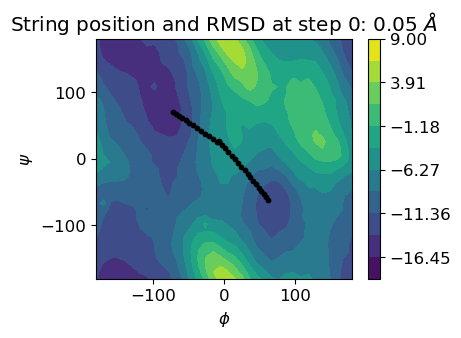

[output:0]

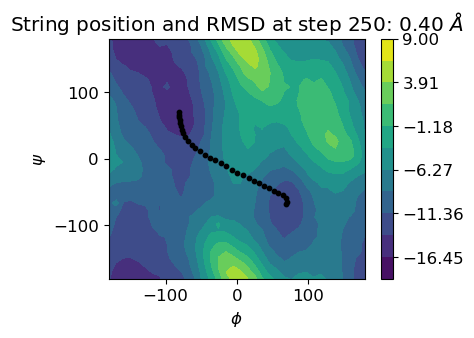

[output:0]

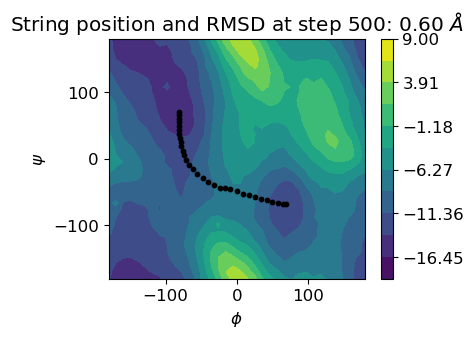

[output:0]

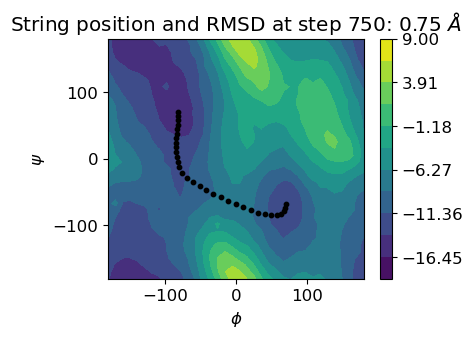

[output:0]

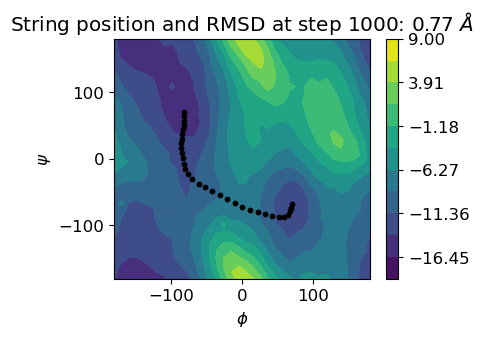

[output:0]

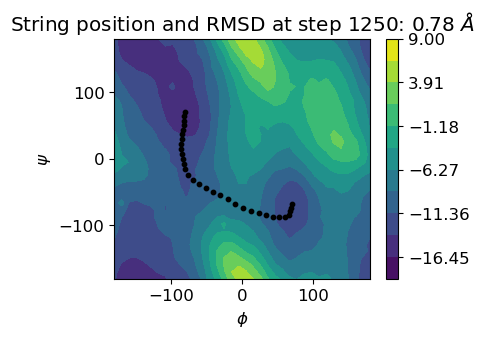

Received Keyboard Interrupt. Sending signal SIGINT to engines...


Stopping controller


Stopping cluster <Cluster(cluster_id='1673651724-95sw', profile='default', controller=<running>, engine_sets=['1673651725'])>


Controller stopped: {'exit_code': 0, 'pid': 7988, 'identifier': 'ipcontroller-1673651724-95sw-7981'}
Stopping engine(s): 1673651725


In [6]:
%%px
F = []
Y = []
RMS = []
for istep in range(firststep,nsteps,skip):
    for ibead in range(nbeads):
        if not (ibead % nproc == rank): continue
        if rank == 0: settings.set_verbosity(0)
        evolve_String(ibead,istep)
        if rank == 0: settings.set_verbosity(5)
    comm.barrier()
    if rank == 0:
        settings.set_verbosity(0)
        # Now gather beads and update with HFB
        trj = charmm_file.CharmmFile(
            file_name='{}/dcd_evolve/evolve_{}.dcd'.format(path,istep),
            file_unit=2,
            formatted=False,
            read_only=False)
        traj_write = '''
        traj iwrite {} nwrite 1 nfile {}
        '''.format(trj.file_unit,nbeads)
        pycharmm.lingo.charmm_script(traj_write)
        
        for ibead in range(nbeads):
            read.pdb('{}/pdb_evolve/evolve_{}-{}.pdb'.format(path,ibead,istep))
            pycharmm.lingo.charmm_script('traj write')
        trj.close()
        hfb_refine = '''
        define rcs select type n .or. type c .or. type ca -
           .or. type nt .or. type cy end
        trek maxpoint {} select rcs end mass
        traj read name {}/dcd_evolve/evolve_{}.dcd begin 1 skip 1 
        !traj read name {}/dcd_evolve/refine_{}.dcd begin 1 skip 1 
        fp trnc 24
        !wrkp trnc 24 bead {} grid {} rtyp 1 rfrc 10.0 step 0.00125
        traj write name {}/dcd_evolve/refine_{}.dcd restart cpr/diala.cpr
        quit'''.format(nbeads,path,istep,path,istep,nbeads,nbeads*2,path,istep+1)
        pycharmm.lingo.charmm_script(hfb_refine)
        if istep % update == 0:
            settings.set_verbosity(0)
            trj = charmm_file.CharmmFile(
                file_name='{}/dcd_evolve/refine_{}.dcd'.format(path,istep+1),
                file_unit=1,
                formatted=False,
                read_only=True)
            traj_read = '''
            traj firstunit {} nunit 1
            '''.format(trj.file_unit)
            pycharmm.lingo.charmm_script(traj_read)
            rmstot = 0.0
            for ibead in range(nbeads):
                pycharmm.lingo.charmm_script('traj read')
                write.coor_pdb('{}/pdb_evolve/refine_{}-{}.pdb'
                               .format(path,ibead,istep+1))
                rmstot += getRMSD('{}/pdb_evolve/refine_{}-0.pdb'
                                  .format(path,ibead),
                                  '{}/pdb_evolve/refine_{}-{}.pdb'
                                  .format(path,ibead,istep+1),select=RCS)
                f,y = getFY(Fcons,Ycons)
                F.append(f)
                Y.append(y)
            RMS.append(rmstot/nbeads)
            print('Average RMS from step {} to step {} is {:5.3f}'
                  .format(istep,istep+1,RMS[-1]))
            print('Length of RMS',len(RMS))
            if len(RMS) == 1:
                pltFY(np.asarray(F),
                      np.asarray(Y),
                      np.asarray(F),
                      np.asarray(Y),
                      istep,
                      RMS[-1])
            else:
                print('Reshaping ({},{})'.format(len(RMS),nbeads))
                pltFY(np.reshape(np.asarray(F),(len(RMS),nbeads))[-1,:],
                      np.reshape(np.asarray(Y),(len(RMS),nbeads))[-1,:],
                      np.reshape(np.asarray(F),(len(RMS),nbeads))[0,:],
                      np.reshape(np.asarray(Y),(len(RMS),nbeads))[0,:],
                      istep,
                      RMS[-1])
            print('Finished step {}'.format(istep))
        settings.set_verbosity(5)
    comm.barrier()
comm.barrier()

# Summary
## Do you see how the minimum energy path through the $\phi,\psi$ landscape moves through successive iterations of the string to follow the energy surface?
## This example should serve as a jumping off point for building other examples of MPI parallel applications using mpi4py and pyCHARMM
